In [22]:
import formulaic
import pymc as pm
import pandas as pd

data = pd.read_csv("../../single_parameter/combined_data/statistics.csv")


# Dummy variables for Module and Parameters
model_formula = 'Coverage ~ 0 + C(TargetModule) + C(TuningParameters, contr.treatment("NONE"))'
design_matrix = formulaic.model_matrix(model_formula, data=data)

module_matrix = design_matrix.rhs.iloc[:, :24]
parameter_matrix = design_matrix.rhs.iloc[:, 24:]

# Dummy variables for interaction terms
model_formula = 'Coverage ~ 0 + C(TargetModule) : C(TuningParameters)'
design_matrix = formulaic.model_matrix(model_formula, data=data)

# Filter out columns that contain 'T.NONE' in their name
columns_to_drop = [col for col in design_matrix.rhs.columns if 'T.NONE' in col]

# Drop the identified columns
design_matrix.rhs.drop(columns=columns_to_drop, axis=1, inplace=True)
interaction_matrix = design_matrix.rhs.iloc[:,:]


In [23]:
with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.0)
    sigma = pm.Exponential('sigma', 1.0)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma, shape=24)

    # Parameter effects
    b_p = pm.Normal('b_p', mu=0, sigma = 0.5, shape= 12)

    # Interaction effects
    g_mp = pm.Normal('g_mp', mu=0, sigma = 0.5, shape=288)
    
    # Activate the correct dummy variables
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_b = pm.math.dot(parameter_matrix, b_p)
    logit_g = pm.math.dot(interaction_matrix, g_mp)
    combined = logit_a + logit_b + logit_g

    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(combined))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200) # Disperion parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=design_matrix.lhs['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True, progressbar=True)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, a_m, b_p, g_mp, theta]


Output()

ValueError: Not enough samples to build a trace.

In [ ]:
import arviz as az

az.to_netcdf(trace, "model_3_trace.nc")

In [ ]:
az.loo(az.from_netcdf("model_3_trace.nc"))

Sampling: [a_bar, a_m, b_p, g_mp, sigma, theta]


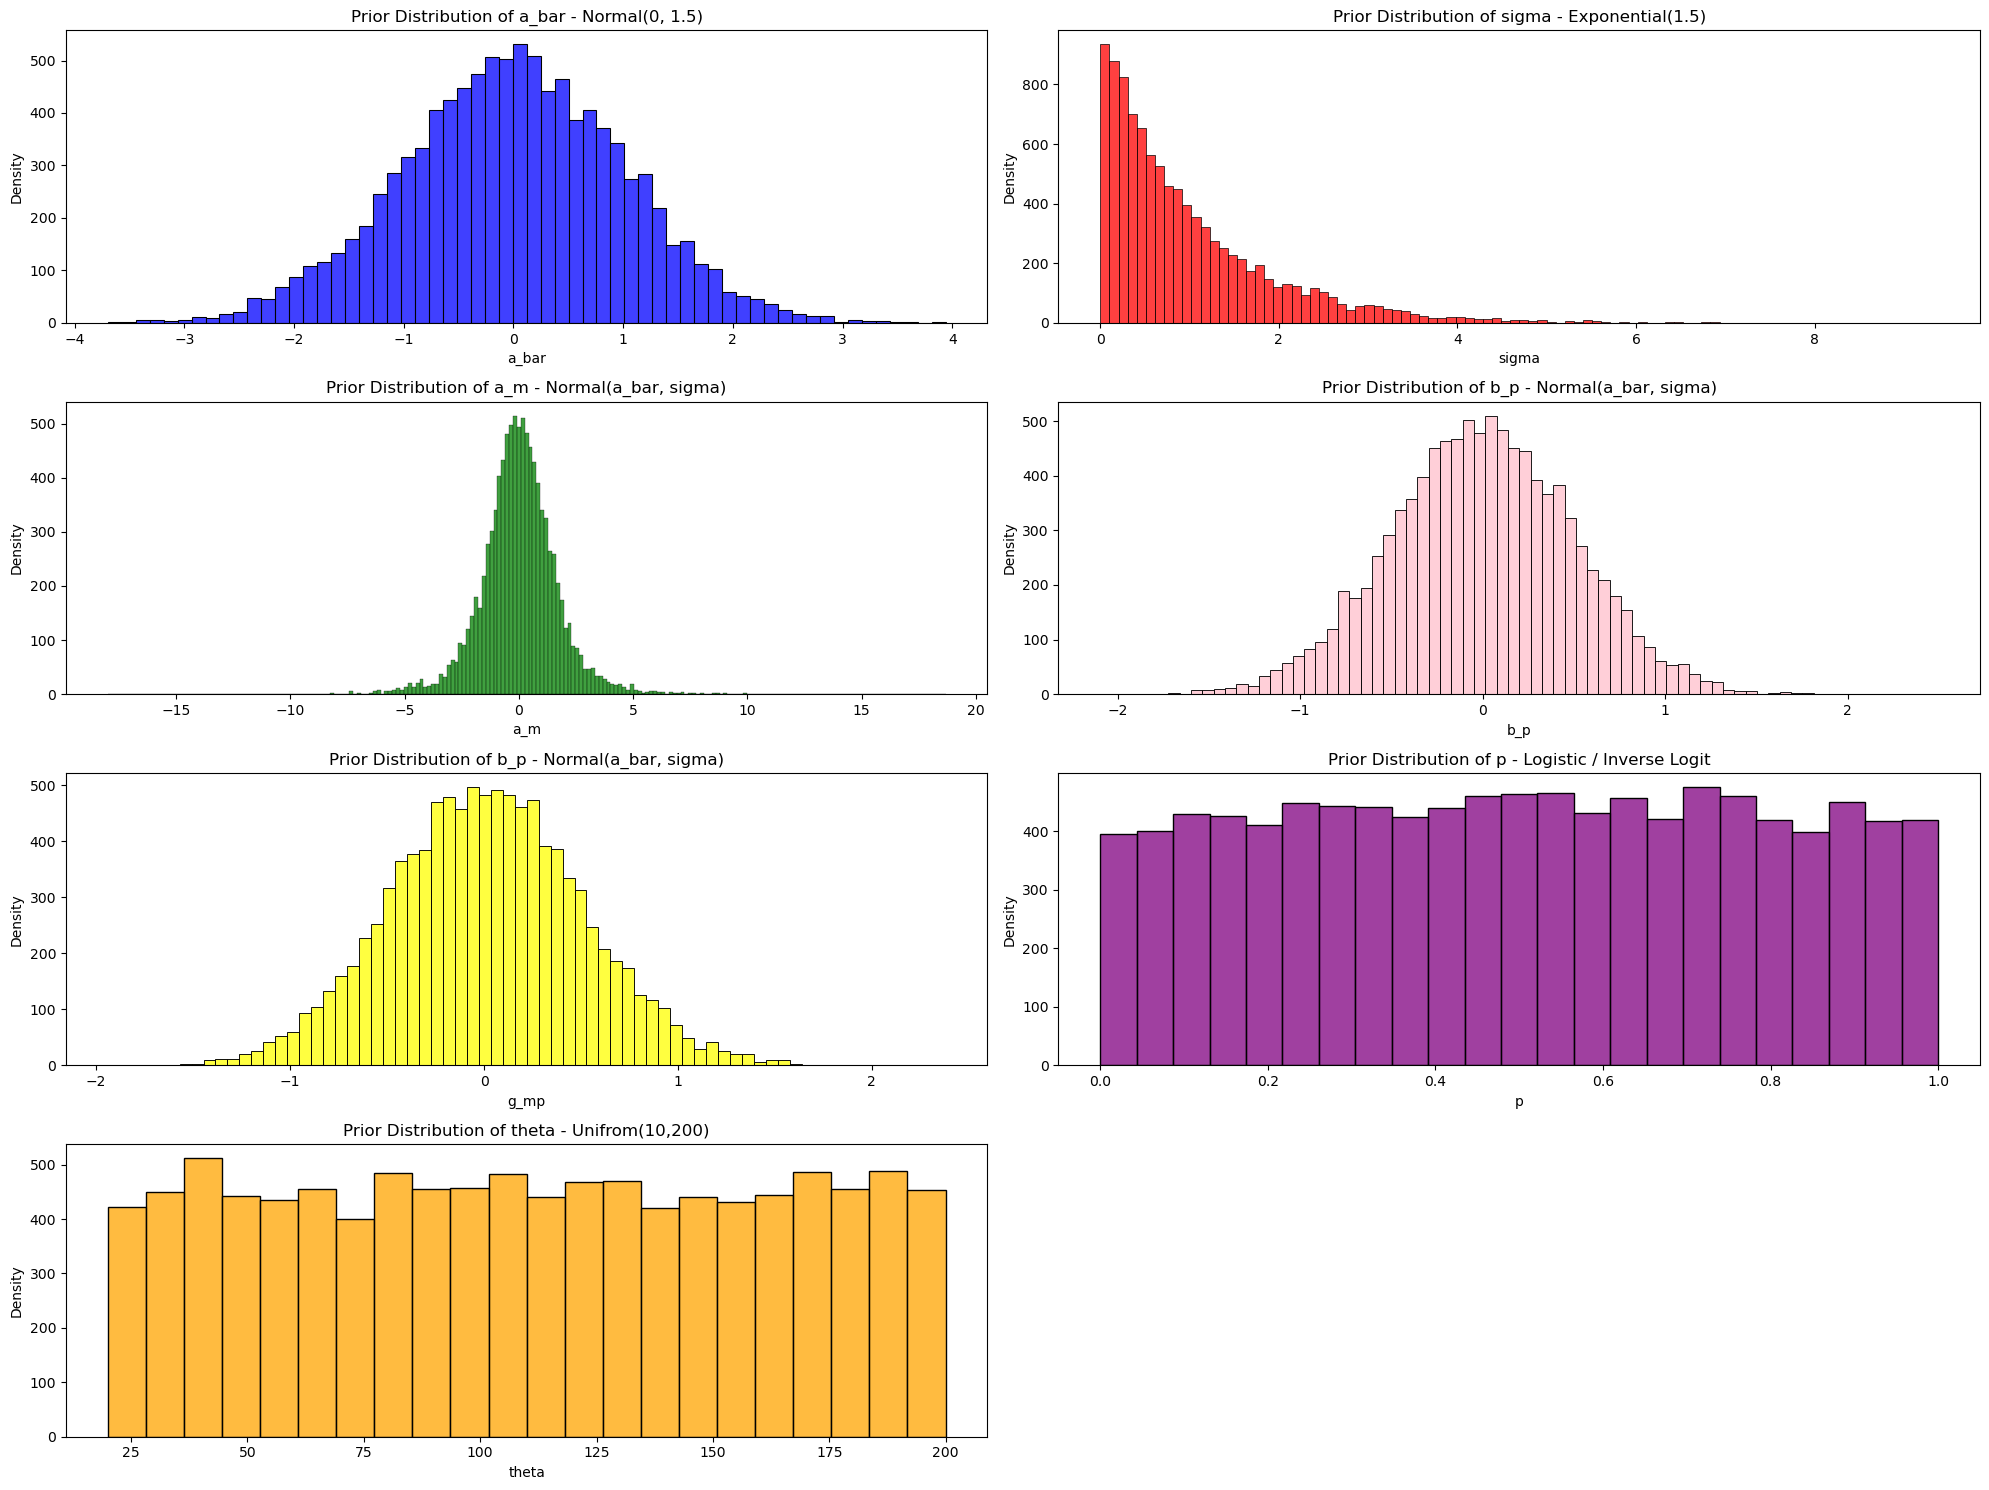

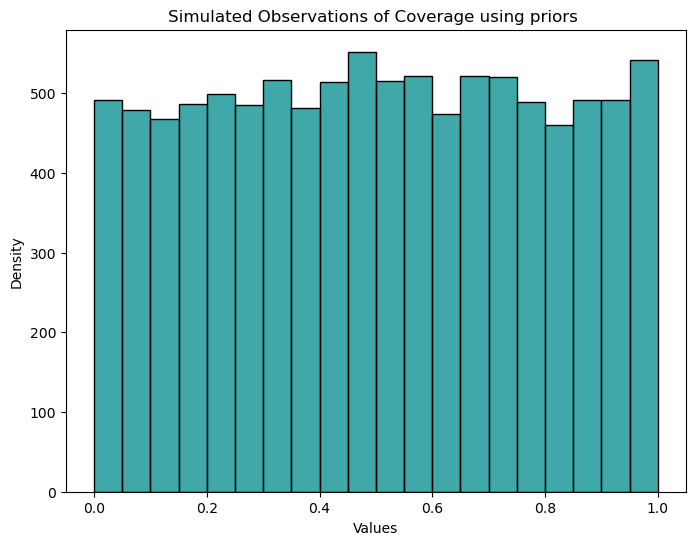

In [21]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.0)
    sigma = pm.Exponential('sigma', 1.0)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma)

    # Parameter effects
    b_p = pm.Normal('b_p', mu=0, sigma = 0.5)

    # Interaction effects
    g_mp = pm.Normal('g_mp', mu=0, sigma = 0.5)
    
    # Link function (logit), unbounded to (0,1) probability
    combined = a_m + b_p + g_mp
    p = pm.Deterministic('p', pm.math.sigmoid(combined))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200) # Disperion parameter
   
    # Sample Priors
    idata = pm.sample_prior_predictive(samples=10000)

# Fetch and flatten priors
prior_a_bar = idata.prior['a_bar'].values.flatten()
prior_sigma = idata.prior['sigma'].values.flatten()
prior_a_m = idata.prior['a_m'].values.flatten()
prior_b_p = idata.prior['b_p'].values.flatten()
prior_g_mp = idata.prior['g_mp'].values.flatten()
prior_p = idata.prior['p'].values.flatten()
prior_theta = idata.prior['theta'].values.flatten()


# Sample one data point from each combination of priors
simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


plt.figure(figsize=(20, 15))

# a_bar
plt.subplot(4, 2, 1)
sns.histplot(prior_a_bar, color='blue')
plt.title('Prior Distribution of a_bar - Normal(0, 1.5)')
plt.xlabel('a_bar')
plt.ylabel('Density')

# sigma
plt.subplot(4, 2, 2)
sns.histplot(prior_sigma, color='red')
plt.title('Prior Distribution of sigma - Exponential(1.5)')
plt.xlabel('sigma')
plt.ylabel('Density')

# a_m
plt.subplot(4, 2, 3)
sns.histplot(prior_a_m, color='green')
plt.title('Prior Distribution of a_m - Normal(a_bar, sigma)')
plt.xlabel('a_m')
plt.ylabel('Density')

# b_p
plt.subplot(4, 2, 4)
sns.histplot(prior_b_p, color='pink')
plt.title('Prior Distribution of b_p - Normal(a_bar, sigma)')
plt.xlabel('b_p')
plt.ylabel('Density')

# g_mp
plt.subplot(4, 2, 5)
sns.histplot(prior_g_mp, color='yellow')
plt.title('Prior Distribution of b_p - Normal(a_bar, sigma)')
plt.xlabel('g_mp')
plt.ylabel('Density')

# p
plt.subplot(4, 2, 6)
sns.histplot(prior_p, color='purple')
plt.title('Prior Distribution of p - Logistic / Inverse Logit')
plt.xlabel('p')
plt.ylabel('Density')

# theta
plt.subplot(4, 2, 7)
sns.histplot(prior_theta, color='orange')
plt.title('Prior Distribution of theta - Unifrom(10,200)')
plt.xlabel('theta')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Predicated observations
plt.figure(figsize=(8, 6))
sns.histplot(simulated_observations, bins=np.arange(0, 1.05, 0.05), color='darkcyan')
plt.title('Simulated Observations of Coverage using priors ')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()